In [28]:
import numpy as np
import csv
import pandas as pd
import datetime
import timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tools.eval_measures import rmse
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import warnings

In [29]:
warnings.filterwarnings("ignore")
file = open("../Simplified_Dataset.csv")
csvreader = csv.reader(file)
rows = []
header = next(csvreader)
for row in csvreader:
    rows.append(row)
file.close()

In [30]:
def add_minutes(Time, period):
    res = Time + datetime.timedelta(minutes = period)
    return res

account = input()
sum = 0.0
start_time = datetime.datetime.strptime("2020-10-04 14:30:00", "%Y-%m-%d %H:%M:%S")
end_time = datetime.datetime.strptime("2020-10-05 12:20:00", "%Y-%m-%d %H:%M:%S")
period = 1
Time = start_time
sum = 0
index = 0
x = []
x_t = []
y = []

while Time <= end_time:
    x.append(index)
    x_t.append(Time)
    Time = add_minutes(Time, period)
    index = index + 1

Time = start_time

for row in rows:
    str = row[4]
    str = str.removesuffix(" +UTC")
    cur_time = datetime.datetime.strptime(str, "%b-%d-%Y %I:%M:%S %p")
    while Time <= cur_time:
        y.append(sum)
        Time = add_minutes(Time, period)

    if row[1] == account:
        sum = sum - float(row[3])
    if row[2] == account:
        sum = sum + float(row[3])

while Time <= end_time:
    y.append(sum)
    Time = add_minutes(Time, period)

new_end = int(0.5 * len(x))
x = x[: new_end]
y = y[: new_end]
x_t = x_t[: new_end]

df = pd.DataFrame()
df['Time Stamps'] = x_t
df['Amount'] = y
df

,Time Stamps,Amount
0,2020-10-04 14:30:00,1478.940532
1,2020-10-04 14:31:00,1540.896094
2,2020-10-04 14:32:00,1729.286787
3,2020-10-04 14:33:00,1798.814136
4,2020-10-04 14:34:00,1899.413158
...,...,...
650,2020-10-05 01:20:00,100685.776524
651,2020-10-05 01:21:00,100685.776524
652,2020-10-05 01:22:00,100685.776524
653,2020-10-05 01:23:00,100685.776524


(655, 1)

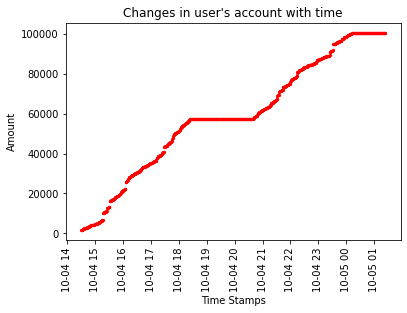

In [42]:
x = np.array(x).reshape(-1, 1)
y = np.array(y)

plt.scatter(df['Time Stamps'], df['Amount'], s = 5, color = 'red')
plt.xlabel('Time Stamps')
plt.title("Changes in user's account with time")
plt.ylabel('Amount')
plt.xticks(rotation = 'vertical')

x.shape

In [32]:
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = "AIC")
    print("P - value : ", dftest[1])

ad_test(y)

P - value :  0.28922342664996237


In [33]:
train_size = int(0.7 * x.shape[0])

y_train = y[:train_size]
y_test = y[train_size:]

x_train = x[:train_size]
x_test = x[train_size:]

print(y_train.shape, y_test.shape)

(458,) (197,)


In [34]:
stepwise_fit = auto_arima(y,          
                      seasonal=True,   
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=9369.883, Time=0.52 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=9794.996, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=9590.793, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=9368.181, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=9369.841, Time=0.12 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=9369.854, Time=0.11 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=9367.887, Time=0.38 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=9369.883, Time=0.62 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=9371.608, Time=0.24 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=9371.571, Time=0.20 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=9371.757, Time=0.57 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=9369.791, Time=0.47 sec

Best model:  ARIMA(1,2,2)(0,0,0)[0]          
Total fit time: 3.326 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  655
Model:               SARIMAX(1, 2, 2)   Log Likelihood               -4679.944
Date:                Thu, 05 May 2022   AIC                           9367.887
Time:                        03:46:14   BIC                           9385.814
Sample:                             0   HQIC                          9374.839
                                - 655                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9722      0.041    -23.535      0.000      -1.053      -0.891
ma.L1          0.0107      0.064      0.166      0.868      -0.115       0.137
ma.L2         -0.8986      0.046    -19.641      0.000      -0.988      -0.809
sigma2        9.8e+04   1337.427     73.274      0.000    9.54e+04    1.01e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             87349.28
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                             6.67
Prob(H) (two-sided):                  0.00   Kurtosis:                        58.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
arima_order = stepwise_fit.get_params().get("order")

In [36]:
history = [x for x in y_train]
predictions = list()
for t in range(len(y_test)):
	model = ARIMA(history, order=arima_order)
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = y_test[t]
	history.append(obs)

In [37]:
len(predictions)
# train_size, test_end

197

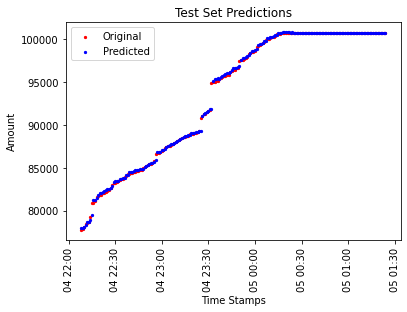

In [38]:
plt.scatter(x_t[train_size:], y[train_size:], s = 5, color = "red", label = "Original")
plt.xticks(rotation = 'vertical')
plt.xlabel('Time Stamps')
plt.ylabel('Amount')
plt.title('Test Set Predictions')
plt.scatter(x_t[train_size:], predictions, s = 5, color = "blue", label = "Predicted")
plt.legend()
plt.show()

In [39]:
print("Mean : ", y_test.mean())

Mean :  93473.32376452067


In [41]:
print("RMSE : ", rmse(y_test, predictions))
print("MSE : ", mean_squared_error(y_test, predictions))
print("MAE : ", mean_absolute_error(y_test, predictions))
print("R2 : ", r2_score(y_test, predictions))

RMSE :  286.14063780880275
MSE :  81876.46460562843
MAE :  114.04408127041411
R2 :  0.9985538347181823
